## Recommendation Performance

In [12]:
ROOT="/home/sl1471/workspace/experiments/"
best_setting = {'ml-1m': {'MF': ['/logs/f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log'], 
                          'FedMF': ['/logs/f2rec_train_and_eval_FedMF_lr0.01_reg0.1_losspairwisebpr_local1_fedavg.log'], 
                          'FairMF': [],
                          'F2MF': []
                         },
                'amz_Books': {'MF': ['/logs/f2rec_train_and_eval_MF_lr0.00001_reg1.0_losspairwisebpr.log'], 
                              'FedMF': [],
                              'FairMF': [],
                              'F2MF': []
                             },
                'amz_Movies_and_TV': {'MF': ['/logs/f2rec_train_and_eval_MF_lr0.0001_reg1.0_losspairwisebpr.log'], 
                                      'FedMF': ['/logs/f2rec_train_and_eval_FedMF_lr0.003_reg0.1_losspairwisebpr_local1_fedavg.log'], 
                                      'FairMF': ['/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_gactivity.log'],
                                      'F2MF': []
                                     }
               }

In [13]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import argparse
from argparse import Namespace

def read_line_number(file_path, line_num):
    with open(file_path, 'r') as fin:
        for i,line in enumerate(fin):
            if i == line_num:
                return line.strip()
    return ""

def extract_args(log_path):
    print(log_path)
    argstr = read_line_number(log_path, 1)
    if 'fair_lambda' not in argstr:
        argstr = argstr[:-1] + ', fair_lambda=0.1)'
    if 'fair_rho' not in argstr:
        argstr = argstr[:-1] + ', fair_rho=1)'
    if 'fair_group_feature' not in argstr:
        argstr = argstr[:-1] + f", fair_group_feature='{group_feature}')"
    args = eval(argstr)
    return args

def extract_epochwise_result(log_path):
    '''
    @output:
    - log_result: [round_result]
        - round_result: [epoch_result]
            - epoch_result: {metric: value}
    '''
    log_result, round_result = [], []
    wait_flag, read_flag = False, False
    with open(log_path, 'r') as fin:
        for i,line in enumerate(fin):
            if 'Epoch ' in line:
                wait_flag = True
                if 'Epoch 1' in line:
                    round_result = []
            elif 'Result dict:' in line:
                if wait_flag:
                    read_flag = True
                    wait_flag = False
                else:
                    log_result.append(round_result)
            elif read_flag:
                read_flag = False
                round_result.append(eval(line))
    return log_result
                

In [26]:
group_feature = 'activity'
# data_key = 'ml-1m'
data_key = 'amz_Movies_and_TV'
# data_key = 'amz_Books'

observation_result = extract_epochwise_result(ROOT + data_key + best_setting[data_key]['FedMF'][0])
print(f"#round: {len(observation_result)}")

#round: 1


In [27]:
pick_round = 0
training_curves = {metric: [epoch_result[metric] for epoch_result in observation_result[pick_round]] 
                   for metric in observation_result[pick_round][0]}

In [28]:
training_curves

{'HR@1': [0.30265995686556435,
  0.30300833635375135,
  0.30772058823529413,
  0.3179468242245199,
  0.3111271155923659,
  0.3078034682080925,
  0.3210565476190476,
  0.3069952881478797,
  0.3153252480705623,
  0.3011194029850746,
  0.3142016188373804,
  0.3060485331401666,
  0.2994830132939439,
  0.3066328379847771,
  0.3005524861878453],
 'P@1': [0.30265995686556435,
  0.30300833635375135,
  0.30772058823529413,
  0.3179468242245199,
  0.3111271155923659,
  0.3078034682080925,
  0.3210565476190476,
  0.3069952881478797,
  0.3153252480705623,
  0.3011194029850746,
  0.3142016188373804,
  0.3060485331401666,
  0.2994830132939439,
  0.3066328379847771,
  0.3005524861878453],
 'RECALL@1': [0.049547585261360313,
  0.049273142235839,
  0.05014068350069197,
  0.05204120386812142,
  0.05079180609768871,
  0.05010448434528749,
  0.05231610304378721,
  0.04890330628116911,
  0.05009293950545146,
  0.04869928485870278,
  0.05134629792049993,
  0.05001894058946389,
  0.0487519554772168,
  0.0496

## 1. Example Performance Uploads with Noises

In [53]:
import numpy as np
X = [0.47355184638423353,0.4880126114596745,0.48197951076343787,0.4910955877995803,0.49148326528871633,0.4942378553333534,0.49584690352035904,0.4998314645835072,0.5052953918607438,0.5029510307609053]
A = np.array([X,[0]*len(X)])
personal_noise = (0.3 * np.random.randn(2)).reshape((2,1))
print(personal_noise)
B = A + personal_noise
C = B + 0.3 * np.random.randn(len(A),len(A[0]))

[[-0.05284641]
 [ 0.36695406]]


In [55]:
A.shape

(2, 10)

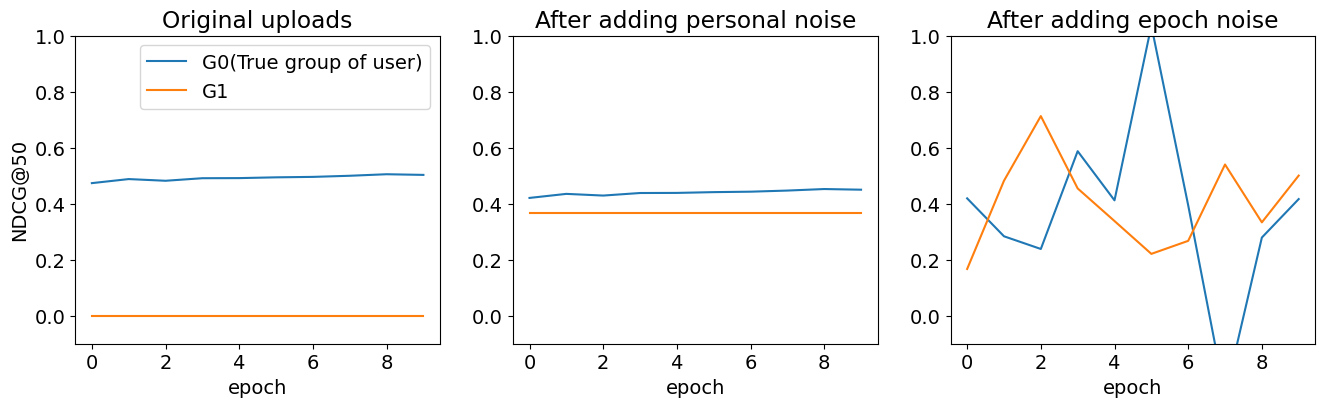

In [69]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '14'

plt.figure(figsize = (16, 4))
plt.subplot(1,3,1)
plt.plot(A.transpose())
plt.ylim(-0.1,1.0)
plt.ylabel('NDCG@50')
plt.xlabel('epoch')
plt.legend(['G0(True group of user)','G1'])
plt.title('Original uploads')

plt.subplot(1,3,2)
plt.plot(B.transpose())
plt.ylim(-0.1,1.0)
plt.xlabel('epoch')
plt.title('After adding personal noise')

plt.subplot(1,3,3)
plt.plot(C.transpose())
plt.ylim(-0.1,1.0)
plt.xlabel('epoch')
plt.title('After adding epoch noise')
plt.show()

## 2. Group Differences during Training

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
ROOT="/home/sl1471/workspace/experiments/"
group_feature = 'activity'
best_setting = {'ml-1m': {'MF': [], 
                          'FedMF': [], 
                          'FairMF': [
                              f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.9_g{group_feature}.log'
                          ],
                          'F2MF': []
                         },
               'amz_Movies_and_TV': {'MF': [], 
                          'FedMF': [], 
                          'FairMF': [
#                               '/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_gactivity.log'
#                               '/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.7_gactivity.log'
#                               ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.5_gactivity.log'
#                               ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.3_gactivity.log'
#                               ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_gactivity.log'
                              '/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_gactivity.log'
                              ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.3_gactivity.log'
                              ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.5_gactivity.log'
                              ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.7_gactivity.log'
#                               ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.9_gactivity.log'
                          ],
                          'F2MF': []
                         }}

In [3]:
from utils import extract_args, extract_epochwise_result
import numpy as np
groups = []
# data_key = 'ml-1m'
data_key = 'amz_Movies_and_TV'
# data_key = 'amz_Books'
training_curves = {} # {fair_lambda: {group_feature: [values]}}
D = {} # {fair_lambda: {group_feature: [values]}}
for log_name in best_setting[data_key]['FairMF']:
    log_file_path = ROOT + data_key + log_name
    args = extract_args(log_file_path)
    observation_result = extract_epochwise_result(log_file_path, 'Previous statistics:')
    if len(groups) == 0:
        groups = [G for G in observation_result[0]]
    training_curves[args.fair_lambda] = {G: np.array([epoch_result[G] for epoch_result in observation_result])
                                         for G in groups}
    D_log = extract_epochwise_result(log_file_path, 'D:', next_line = False)
    D[args.fair_lambda] = {G: np.array([epoch_result[G] for epoch_result in D_log])
                                         for G in groups}
# print(training_curves)

/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_gactivity.log
/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.3_gactivity.log
/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.5_gactivity.log
/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.7_gactivity.log


In [4]:
group_differences = {} # {fair_lambda: [value]}
for lbd, group_curves in training_curves.items():
    L = len(group_curves[groups[0]])
    diff_sum,diff_count = np.zeros(L),0.
    for i,G0 in enumerate(groups):
        curve0 = group_curves[G0]
        for G1 in groups[i+1:]:
            curve1 = group_curves[G1]
            diff_sum += np.abs(curve1 - curve0)
            diff_count += 1
    group_differences[lbd] = diff_sum / diff_count
print(group_differences)

{0.1: array([0.00027719, 0.0005916 , 0.0019003 , 0.00153554, 0.00293763,
       0.00605801, 0.01107891, 0.01479256, 0.0148782 , 0.01497167,
       0.01753546, 0.0199757 , 0.02047253, 0.02018394, 0.01981026,
       0.0198364 , 0.02104794, 0.02118506, 0.02165251, 0.0228815 ,
       0.02359744, 0.02461774, 0.02453127, 0.02445596, 0.02407771,
       0.02413054, 0.02450641, 0.02460804, 0.02427547]), 0.3: array([0.00027719, 0.00058164, 0.00107111, 0.00116215, 0.00182029,
       0.00373691, 0.00724065, 0.00979276, 0.00951237, 0.00870101,
       0.00972246, 0.01119996, 0.01171017, 0.01137573, 0.01087045,
       0.01088986, 0.01176676, 0.011707  , 0.01180801, 0.01287945,
       0.01367372, 0.01464599, 0.01470833, 0.01464954, 0.01440611,
       0.01425413, 0.01453497, 0.01490729]), 0.5: array([0.00027719, 0.00057036, 0.00041977, 0.00091842, 0.01084737,
       0.0002029 , 0.00020554, 0.00340427, 0.02161226, 0.01599234,
       0.00061567, 0.00967191, 0.01054475, 0.02428451, 0.05157193,
       0.03

In [5]:
# plot_stats = {f'lambda={lbd}': group_D for lbd, group_D in D.items()}
# title = 'ML1M(activity)'
# plot_stats[title] = group_differences
# print(plot_stats)

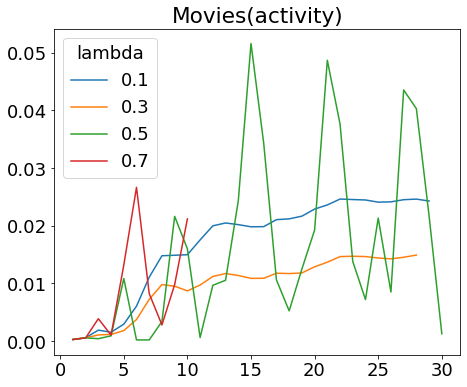

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import plot_multiple_line
plt.rcParams.update({'font.size': 18})
title = f'Movies({group_feature})'
plot_multiple_line({title: group_differences}, [title], ncol = 2,
                   ylabel = '', xlabel = '', legend_title = 'lambda')

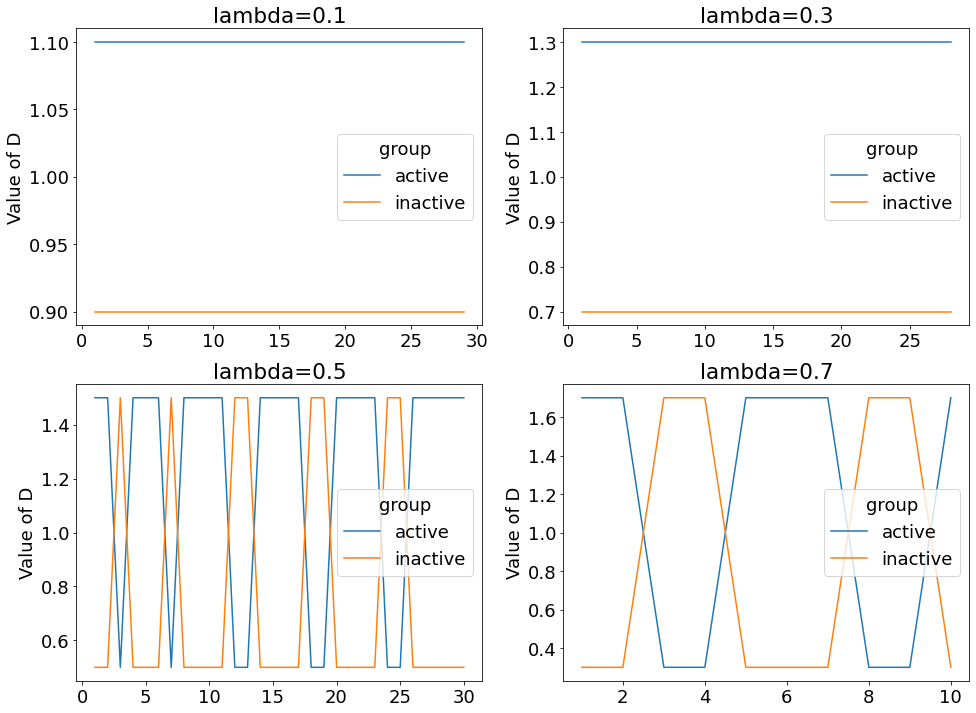

In [7]:
plt.rcParams.update({'font.size': 18})
title = 'ML1M(activity)'
plot_stats = {f'lambda={lbd}': group_D for lbd, group_D in D.items()}
plot_multiple_line(plot_stats, list(plot_stats.keys()), ncol = 2, row_height = 6,
                   ylabel = 'Value of D', xlabel = '', legend_title = 'group')